In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt

In [2]:
aggRF = pd.read_parquet('Data/agg_table_new_zones8Bot.parquet')
pivot_df = aggRF.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0)
adj_matrix = pd.read_parquet('Data/neighbours_zones_8.parquet')
adj_matrix.index = adj_matrix.columns

In [3]:
adj_matrix.index = adj_matrix.index.astype(str)
adj_matrix.columns = adj_matrix.columns.astype(str)

original_area_columns = pivot_df.columns.tolist()

In [4]:
#Combine matrix with pivot
common_indices = list(set(original_area_columns) & set(adj_matrix.index) & set(adj_matrix.columns))
neighbor_df = adj_matrix.loc[common_indices, common_indices]


# Create a dictionary map based on neighbours
h3_indices_in_pivot = original_area_columns # Use the order
neighbor_map = {h3_index: [] for h3_index in h3_indices_in_pivot}

neighbor_df_indices = neighbor_df.index.tolist()

# Walk through of each area
for center_h3 in h3_indices_in_pivot:
    if center_h3 in neighbor_df_indices:
        # Find neighbours
        neighbors = neighbor_df.columns[neighbor_df.loc[center_h3] == 1].tolist()
        # Add neighbours 
        valid_neighbors = [nb for nb in neighbors if nb in h3_indices_in_pivot and nb != center_h3]
        neighbor_map[center_h3] = valid_neighbors


# Cumulate the orders of neighbours
pivot_df_with_neighbors = pivot_df.copy()
neighbor_sum_cols = []

for h3_index in original_area_columns:
    neighbor_feature_name = f'{h3_index}_neighbor_sum'
    neighbor_sum_cols.append(neighbor_feature_name)
    # Use neighbours of first mapping
    valid_neighbors = [neighbor for neighbor in neighbor_map.get(h3_index, []) if neighbor in pivot_df.columns]

    if valid_neighbors:
        pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
    else:
        pivot_df_with_neighbors[neighbor_feature_name] = 0.0


pivot_df = pivot_df_with_neighbors #The new data frame for going further


C:\Users\freud\AppData\Local\Temp\ipykernel_10996\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_10996\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_10996\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [5]:
# Get time features
pivot_df = pivot_df.reset_index()
pivot_df['hour'] = pivot_df['time_bin'].dt.hour
pivot_df['dayofweek'] = pivot_df['time_bin'].dt.dayofweek 

# Cylcical features (like a clock)
pivot_df['hour_sin'] = np.sin(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['hour_cos'] = np.cos(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['day_sin'] = np.sin(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['day_cos'] = np.cos(2 * np.pi * pivot_df['dayofweek'] / 7)
time_bins_original = pivot_df['time_bin'].copy()

# Remove time features
pivot_df = pivot_df.drop(columns=['time_bin', 'hour', 'dayofweek'])

In [6]:
area_columns = original_area_columns
time_feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
n_areas = len(area_columns)
ordered_cols = area_columns + neighbor_sum_cols + time_feature_cols

In [7]:
pivot_df_for_model = pivot_df[ordered_cols]
data = pivot_df_for_model.values

In [8]:
def create_dataset(data, time_steps=4, n_target_features=None, n_neighbor_features=None, n_time_features=None):
    X, y = [], []
    target_end_idx = n_target_features
    neighbor_end_idx = n_target_features + n_neighbor_features
    time_start_idx = neighbor_end_idx
    for i in range(len(data) - time_steps):
        # area counts lagged
        lagged_targets_part = data[i : i + time_steps, :target_end_idx].flatten()
        # lagged neighbours
        lagged_neighbors_part = data[i : i + time_steps, target_end_idx : neighbor_end_idx].flatten()
        # time features
        current_time_features = data[i + time_steps, time_start_idx :]
        # combination of targets
        X.append(np.concatenate([lagged_targets_part, lagged_neighbors_part, current_time_features]))
        # Objective
        y.append(data[i + time_steps, :target_end_idx])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [9]:
time_steps = 4
n_target_features = n_areas
n_neighbor_features = len(neighbor_sum_cols) 
n_time_features = len(time_feature_cols)

X, y = create_dataset(data, #use features
                      time_steps=time_steps,
                      n_target_features=n_target_features,
                      n_neighbor_features=n_neighbor_features,
                      n_time_features=n_time_features)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False # Last day of set
)
#Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, shuffle=False
)

In [10]:
models = []
predictions = np.zeros_like(y_test)

In [12]:
example_area_for_tuning = '88329b5aa1fffff' #our zone
example_index = area_columns.index(example_area_for_tuning)
print(f'Optimize Hyperparams for zone: {example_area_for_tuning} (Index {example_index})...')

# Definition for grid search finding best params
param_grid = {
    'n_estimators': [100, 200, 300, 400], # Reduziert für schnellere Suche
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2,3]
}

# Erstelle das GridSearchCV-Objekt
rf_for_tuning = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf_for_tuning,
                            param_grid=param_grid,
                            cv=3, #  3 fold cross validation
                            n_jobs=-1, # Parralelisation 
                            verbose=1,
                            scoring='neg_mean_squared_error') # optimisation loss

# Just for one example zone, it is our best one
grid_search.fit(X_train, y_train[:, example_index])

# Found best params
best_params = grid_search.best_params_


Optimize Hyperparams for zone: 88329b5aa1fffff (Index 107)...
Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [13]:
# Get the model with the best parameters you have found
best_params = grid_search.best_params_

num_areas_to_train = y_train.shape[1]
for i in range(num_areas_to_train):
    # Create for each zone a model
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params) # n_jobs=-1 for parralelisation

    # train model for zone i
    rf_model.fit(X_train, y_train[:, i])

    # predict values
    pred = rf_model.predict(X_test)

    # save predictions and save
    predictions[:, i] = pred
    models.append(rf_model)

In [14]:
# Combination of results
y_tests_all = y_test.flatten()
y_preds_all = predictions.flatten()

# Evaluationmetrics
n = len(y_tests_all) # Number of preds
p = X_train.shape[1] # Number of features

rmse = np.sqrt(mean_squared_error(y_tests_all, y_preds_all))
mae = mean_absolute_error(y_tests_all, y_preds_all)
r2 = r2_score(y_tests_all, y_preds_all)
mean_abs_actual = np.mean(np.abs(y_tests_all))
if mean_abs_actual == 0:
    nrmse = np.nan
else:
    nrmse = rmse / mean_abs_actual * 100

# MAPE Calculation
nonzero_indices = y_tests_all != 0
if np.any(nonzero_indices):
    mape = np.mean(np.abs((y_tests_all[nonzero_indices] - y_preds_all[nonzero_indices]) / y_tests_all[nonzero_indices])) * 100
else:
    mape = np.nan

# Adjusted R² Calculation
if n - p - 1 <= 0: 
    adj_r2 = np.nan
else:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'MAPE: {mape:.2f}%')
print(f'NRMSE: {nrmse:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Adjusted R²: {adj_r2:.2f}')

MAPE: 44.94%
NRMSE: 58.04%
RMSE: 2.67
MAE: 1.24
R²: 0.94
Adjusted R²: 0.94


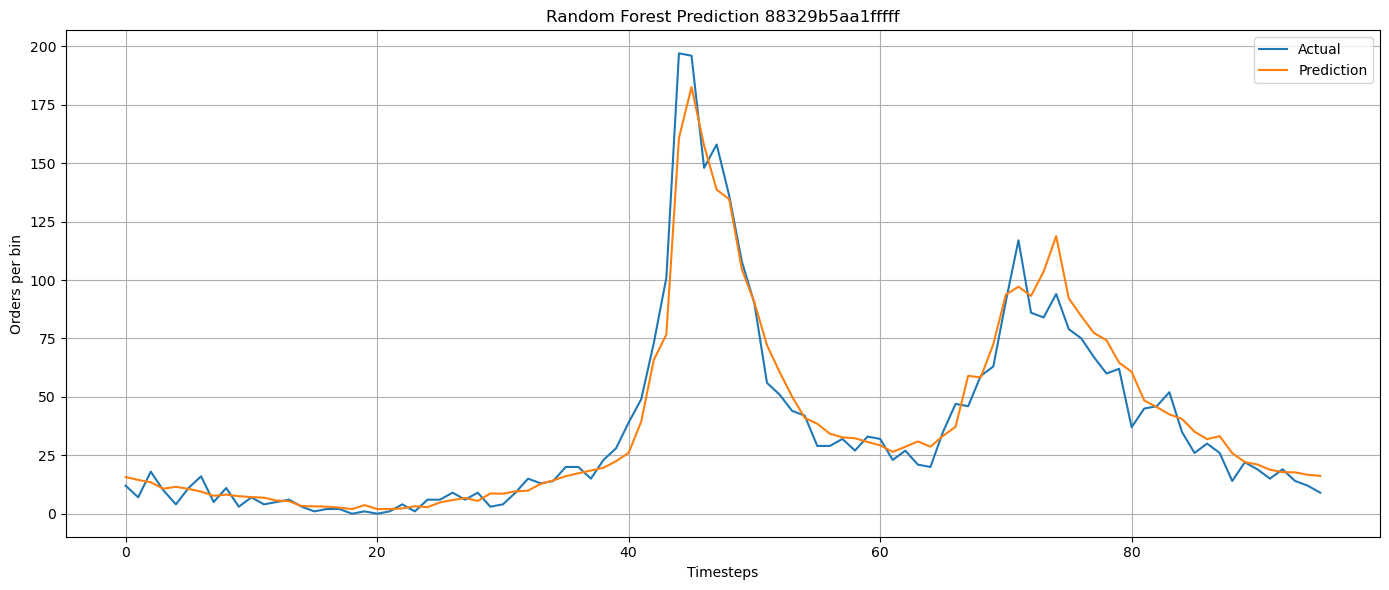

In [15]:
example_area_plot = '88329b5aa1fffff' # Beispielzone für den Plot
example_index_plot = area_columns.index(example_area_plot)

plt.figure(figsize=(14, 6))
plt.plot(y_test[:, example_index_plot], label='Actual')
plt.plot(predictions[:, example_index_plot], label='Prediction')
plt.title(f'Random Forest Prediction {example_area_plot}')
plt.xlabel('Timesteps')
plt.ylabel('Orders per bin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
total_actual_per_step = np.sum(y_test, axis=1)
total_predicted_per_step = np.sum(predictions, axis=1)

rmse_total = np.sqrt(mean_squared_error(total_actual_per_step, total_predicted_per_step))
mae_total = mean_absolute_error(total_actual_per_step, total_predicted_per_step)
r2_total = r2_score(total_actual_per_step, total_predicted_per_step)
mask_total = total_actual_per_step != 0
if np.any(mask_total):
    mape_total = np.mean(np.abs((total_actual_per_step[mask_total] - total_predicted_per_step[mask_total]) / total_actual_per_step[mask_total])) * 100
else:
    mape_total = np.nan

print(f'RMSE (Sum): {rmse_total:.2f}')
print(f'MAE  (Sum): {mae_total:.2f}')
print(f'R²   (Sum): {r2_total:.2f}')
print(f'MAPE (Sum): {mape_total:.2f}%')

RMSE (Sum): 77.73
MAE  (Sum): 44.42
R²   (Sum): 0.99
MAPE (Sum): 9.74%


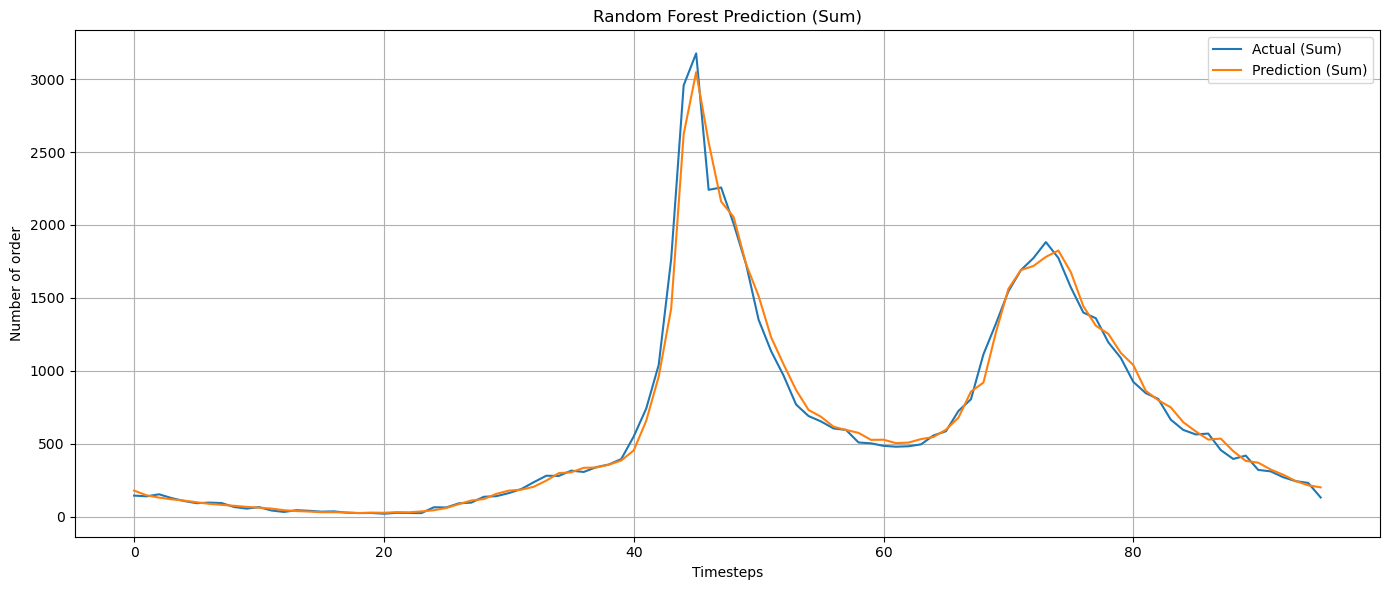

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(total_actual_per_step, label='Actual (Sum)')
plt.plot(total_predicted_per_step, label='Prediction (Sum)')
plt.title('Random Forest Prediction (Sum)')
plt.xlabel('Timesteps')
plt.ylabel('Number of order')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
example_area = '88329b5aa1fffff'  # change the area to observe
example_index = pivot_df.columns.get_loc(example_area)
#np.save('prognose_RF.npy', predictions[:, example_index])

In [20]:
''' 
The parquet we use as predicted demand for our repositioning
'''

test_start_original_index = len(X_train) + len(X_val) + time_steps

test_timestamps = time_bins_original.iloc[test_start_original_index:].reset_index(drop=True)

# DataFrame with predictions
predictions_df_wide = pd.DataFrame(predictions, columns=area_columns)
predictions_df_wide['time_bin'] = test_timestamps

# convert to (long format)
predictions_df_long = pd.melt(
    predictions_df_wide,
    id_vars=['time_bin'],
    var_name='hex_id', # Name of H3 index column
    value_name='predicted_order_count' 
)

predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].round().astype(int)
predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].clip(lower=0)
predictions_df_long['time_bin'] = pd.to_datetime(predictions_df_long['time_bin'])

start_time_str = '2022-10-24 14:00:00'
end_time_str = '2022-10-24 17:00:00'
start_time = pd.to_datetime(start_time_str)
end_time = pd.to_datetime(end_time_str)

filtered_predictions_df = predictions_df_long[
    (predictions_df_long['time_bin'] >= start_time) &
    (predictions_df_long['time_bin'] <= end_time)
].copy() # .copy() for an indipendent cooy

output_path_filtered = 'predicted_values.parquet'
filtered_predictions_df.to_parquet(output_path_filtered)